# DDM for Patient Data

Same as before, parse .mat files to CSV, then attempt to fit data to the hierarchical drift decision model, with 

In [23]:
%matplotlib inline
import warnings; warnings.filterwarnings('ignore')

## Prepare Data

In [2]:
import sys
sys.path.append('../')

In [16]:
from utils import matparser
import glob

data_dir = '../data/patients_data/'

matparser.matparser(data_dir)

In [21]:
# TODO - Place in utils
import csv

def parse_condition(stim_num):
    if stim_num == '1':
        return 'SS'
    if stim_num == '2':
        return 'CP'
    if stim_num == '3':
        return 'CS'
    if stim_num == '4':
        return 'US'

csv_dir = '../data/patients_data/'
subjects = []

for csv_file in glob.glob(csv_dir + 'data*.csv'):
    subject = []
    subj_idx = csv_file[-9:-4]  # Use id from filename
    with open(csv_file, 'r') as f:
        reader = csv.DictReader(f)
        for trial in reader:
            trial['subj_idx'] = subj_idx
            trial['stim'] = parse_condition(trial['stim'])
            subject.append(trial)
    subjects.append(subject)
 
keys = subject[0].keys()

with open('../data/patients.csv', 'w') as out:
        writer = csv.DictWriter(out, keys)
        writer.writeheader()
        for subj in subjects:
            writer.writerows(subj)

## Fit to HDDM model

In [34]:
import hddm

data = hddm.load_csv('../data/patients_clean.csv')

model = hddm.HDDM(data, depends_on={'v': 'stim'})
model.find_starting_values()
model.sample(6000, burn=20)

 [-----------------100%-----------------] 6000 of 6000 complete in 200.6 sec

In [29]:
model.print_stats()

                         mean          std         2.5q          25q          50q          75q        97.5q       mc err
a                     2.93757     0.248159      2.46802      2.77635      2.93172      3.08576       3.4536   0.00518446
a_std                0.730792     0.233801     0.401985     0.568739     0.688453       0.8466       1.3287   0.00717605
a_subj.18438          2.22125     0.107598      2.01855      2.14785      2.21827      2.29168      2.44176   0.00171338
a_subj.18695          2.79992     0.158783      2.51062      2.69048      2.79197      2.90375      3.13279   0.00287265
a_subj.18942           2.2051     0.107233      2.00462      2.13093       2.2028       2.2758      2.42095   0.00180295
a_subj.19109          2.67073     0.574107      1.70703      2.27569      2.62205      3.00633      3.95192    0.0120079
a_subj.19719          3.43921     0.194899      3.07504      3.30138      3.43434      3.56504      3.83249   0.00458775
a_subj.20069          3.48925   

Plotting a
Plotting a_std
Plotting v(CP)
Plotting v(CS)
Plotting v(SS)
Plotting v(US)
Plotting v_std
Plotting t
Plotting t_std


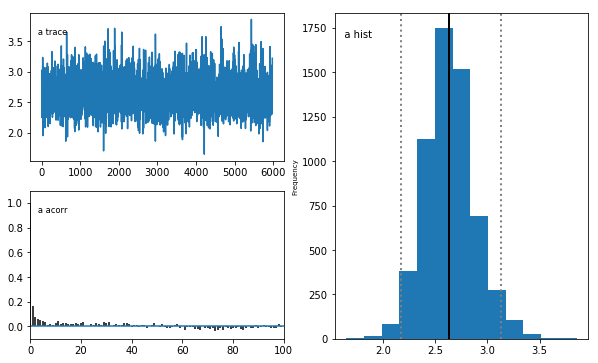

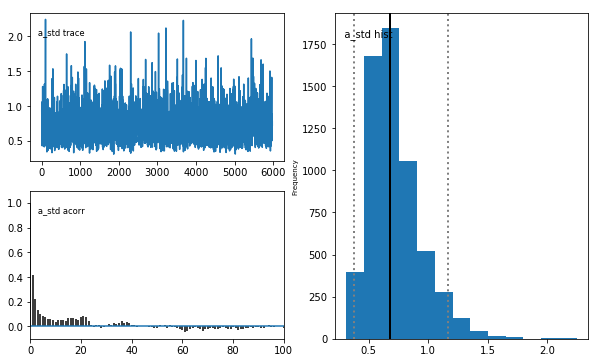

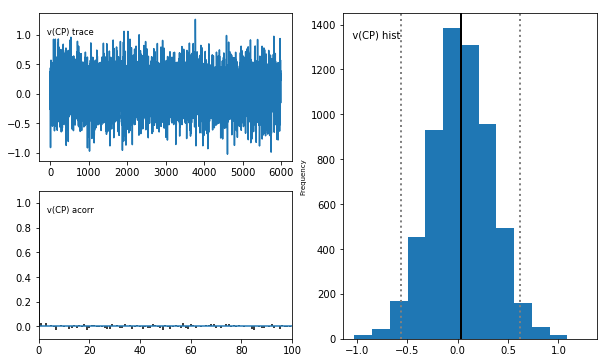

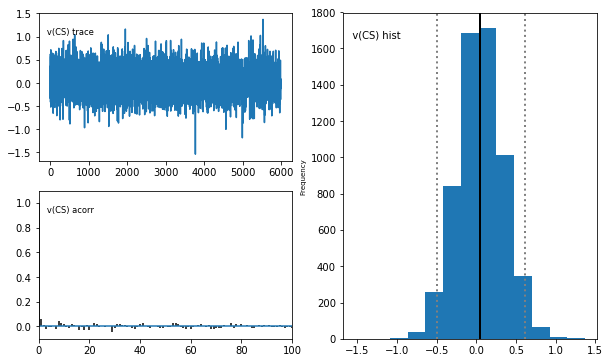

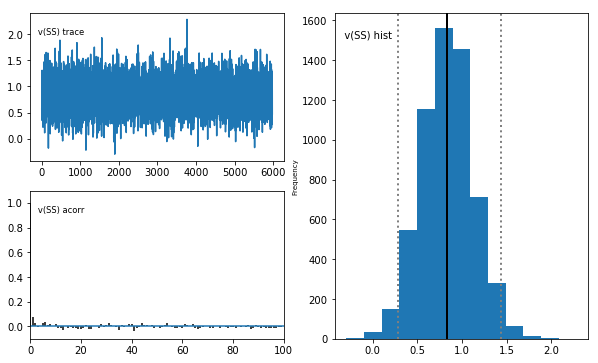

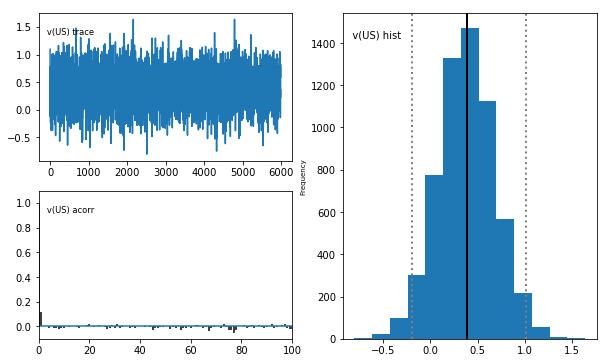

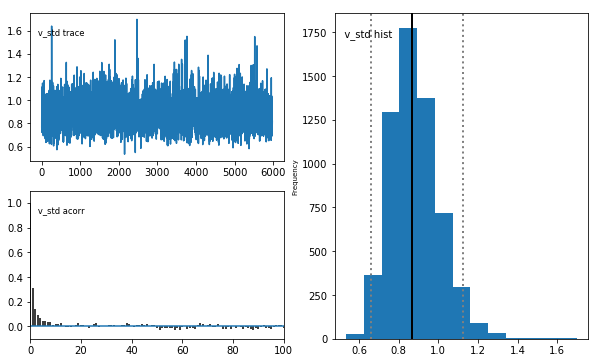

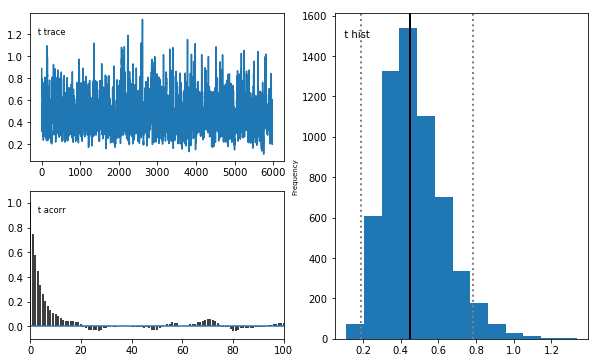

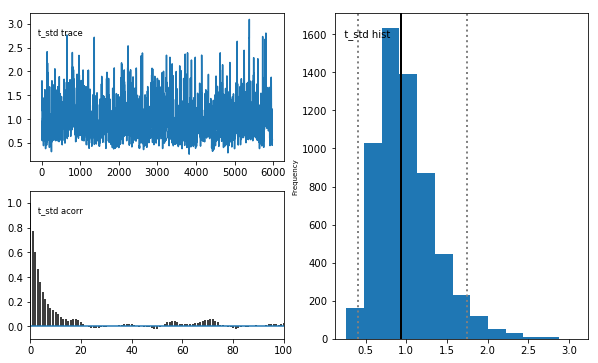

In [37]:
model.plot_posteriors()

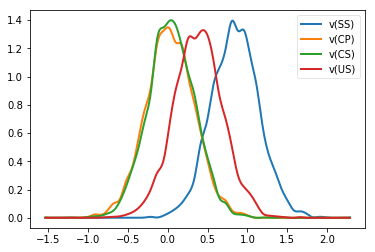

In [35]:
v_SS, v_CP, v_CS, v_US = model.nodes_db.node[['v(SS)', 'v(CP)', 'v(CS)', 'v(US)']]

hddm.analyze.plot_posterior_nodes([v_SS, v_CP, v_CS, v_US])

In [40]:
print('P(SS > US) = ' + str((v_SS.trace() > v_US.trace()).mean()))
print('P(CP > SS) = ' + str((v_CP.trace() > v_SS.trace()).mean()))
print('P(CS > SS) = ' + str((v_CS.trace() > v_SS.trace()).mean()))
print('P(CP > CS) = ' + str((v_CP.trace() > v_CS.trace()).mean()))

P(SS > US) = 0.862876254181
P(CP > SS) = 0.0282608695652
P(CS > SS) = 0.0277591973244
P(CP > CS) = 0.48143812709


### Check Convergence 

In [32]:
models = []
for i in range(5):
    m = hddm.HDDM(data, depends_on={'v': 'stim'})
    m.find_starting_values()
    m.sample(6000, burn=20)
    models.append(m)

hddm.analyze.gelman_rubin(models)

 [-----------------100%-----------------] 6000 of 6000 complete in 193.2 sec

{'a': 1.0004208275167732,
 'a_std': 1.0003031423213653,
 'a_subj.18438': 1.0001549932498317,
 'a_subj.18695': 1.0004439701282759,
 'a_subj.18942': 1.0003736081034036,
 'a_subj.19109': 1.0025949877970943,
 'a_subj.19719': 1.0004406474106762,
 'a_subj.20069': 1.0022167566579805,
 'a_subj.20372': 1.0002377663768598,
 'a_subj.20541': 1.0003131372857155,
 'a_subj.20709': 1.0007775713292291,
 'a_subj.21076': 1.0001191797941615,
 't': 1.0041261451867365,
 't_std': 1.0046000145731637,
 't_subj.18438': 1.0001972053413895,
 't_subj.18695': 1.0001969317573627,
 't_subj.18942': 1.0006364023910332,
 't_subj.19109': 1.0093439743374819,
 't_subj.19719': 1.0034493791915193,
 't_subj.20069': 1.0024347139388876,
 't_subj.20372': 1.0014593353818224,
 't_subj.20541': 1.0014418983240683,
 't_subj.20709': 0.99996861453560482,
 't_subj.21076': 1.0000609525222015,
 'v(CP)': 0.99994152881358211,
 'v(CS)': 1.0003337801190839,
 'v(SS)': 1.0002182799946662,
 'v(US)': 0.99990096467586753,
 'v_std': 0.9999347449614

Models converge!

## Explore Bias

In [48]:
model_bias = hddm.HDDM(data, depends_on={'v': 'stim'}, bias=True)
model_bias.find_starting_values()
model_bias.sample(9000, burn=200)

 [-----------------100%-----------------] 9000 of 9000 complete in 377.9 sec

In [49]:
model_bias.print_stats()

                         mean          std         2.5q          25q          50q          75q        97.5q       mc err
a                     2.83853     0.227006      2.42379      2.68967      2.82664      2.97618      3.32349   0.00421897
a_std                0.659414      0.21952     0.365094     0.512054     0.617063     0.758412      1.21575    0.0058521
a_subj.18438          2.19831     0.108048      2.00314      2.12285      2.19451      2.26779      2.42488   0.00195835
a_subj.18695          2.72684     0.156634      2.44703      2.61595      2.71757      2.82804      3.05622   0.00271279
a_subj.18942          2.15589      0.10923      1.95451      2.08035        2.151      2.22659      2.38716   0.00166397
a_subj.19109          2.61206     0.516162       1.7362      2.25141       2.5678      2.91097      3.72607    0.0100356
a_subj.19719          3.24971     0.163918      2.93852      3.13703      3.24291      3.35776       3.5816   0.00288297
a_subj.20069          3.29185   

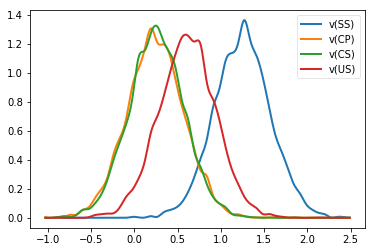

In [50]:
v_bSS, v_bCP, v_bCS, v_bUS = model_bias.nodes_db.node[['v(SS)', 'v(CP)', 'v(CS)', 'v(US)']]

hddm.analyze.plot_posterior_nodes([v_bSS, v_bCP, v_bCS, v_bUS])

### Bias dependent on stimulus type

In [55]:
model_bias = hddm.HDDM(data, depends_on={'v': 'stim', 'z': 'stim'}, bias=True)
model_bias.find_starting_values()
model_bias.sample(10000, burn=200)

 [-----------------100%-----------------] 10000 of 10000 complete in 448.8 sec

In [56]:
model_bias.print_stats()

                         mean          std         2.5q          25q          50q          75q        97.5q       mc err
a                      2.9456     0.257963      2.45679       2.7804      2.93363      3.10038      3.49243   0.00471275
a_std                0.744006     0.245184     0.410632     0.573196     0.695083     0.861974      1.36678   0.00770908
a_subj.18438          2.22336     0.108157      2.01787      2.14965      2.22082      2.29395      2.44574    0.0015609
a_subj.18695          2.79477     0.155762      2.50554      2.68671      2.78882      2.89797      3.11331   0.00212321
a_subj.18942          2.19967     0.105692      1.99944      2.12658      2.19571      2.26828      2.41692   0.00141666
a_subj.19109          2.68192     0.583764      1.72183      2.27619      2.62334      3.02968      3.97272    0.0119671
a_subj.19719          3.44027     0.196063       3.0816      3.30428      3.43015      3.56599      3.85111   0.00357664
a_subj.20069          3.55616   

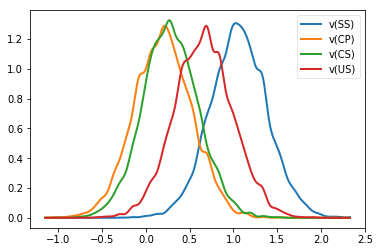

In [57]:
v_bSS, v_bCP, v_bCS, v_bUS = model_bias.nodes_db.node[['v(SS)', 'v(CP)', 'v(CS)', 'v(US)']]

hddm.analyze.plot_posterior_nodes([v_bSS, v_bCP, v_bCS, v_bUS])

In [59]:
print('P(SS > US) = ' + str((v_bSS.trace() > v_bUS.trace()).mean()))
print('P(CP > SS) = ' + str((v_bCP.trace() > v_bSS.trace()).mean()))
print('P(CS > SS) = ' + str((v_bCS.trace() > v_bSS.trace()).mean()))
print('P(CP > CS) = ' + str((v_bCP.trace() > v_bCS.trace()).mean()))

P(SS > US) = 0.802755102041
P(CP > SS) = 0.0326530612245
P(CS > SS) = 0.0437755102041
P(CP > CS) = 0.424081632653


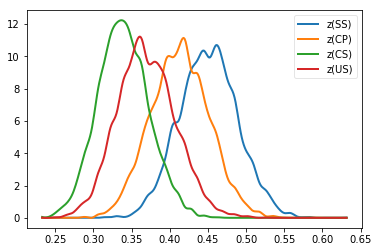

In [58]:
z_bSS, z_bCP, z_bCS, z_bUS = model_bias.nodes_db.node[['z(SS)', 'z(CP)', 'z(CS)', 'z(US)']]

hddm.analyze.plot_posterior_nodes([z_bSS, z_bCP, z_bCS, z_bUS])

In [ ]:
print("Bias Probabilities")
print('P(zSS > zUS) = ' + str((z_bSS.trace() > z_bUS.trace()).mean()))
print('P(zCP > zSS) = ' + str((z_bCP.trace() > z_bSS.trace()).mean()))
print('P(zCS > zSS) = ' + str((z_bCS.trace() > z_bSS.trace()).mean()))
print('P(zCP > zCS) = ' + str((v_CP.trace() > z_bCS.trace()).mean()))